# **Miniproject 2**
## **~Large~ Small Language Model**

### **Objective**
Implement a transformer-based, character-level language model (GPT-like) and train it on the Shakespeare dataset. By the end of this project, you should be able to generate Shakespearean-like text given a seed string.

You will probably want to train the model on a GPU. You can use free GPUs on [Google Colab](https://colab.research.google.com/?utm_source=scs-index).

### **Dataset**:

The Shakespeare dataset contains the complete works of William Shakespeare, including his plays, poems, and sonnets.

[**Download link**](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In a character-level language model, each character in the input data is mapped to its respective index from a dictionary. The input to the model is in the form (B, N), where B is the batch size and N is the number of tokens for each sequence. The model was tested with B=N=128, but feel free to explore different values.

An interface for the dataset class that takes care of tokenization is provided below.



```python
from torch.utils.data import Dataset

class CharDataset(Dataset):
    """
    Emits batches of characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):

        chars = ... # get characters from the input data
        self.stoi = { ch:i for i,ch in enumerate(chars) } # map characters to integer indices

        ...

    def get_vocab_size(self):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        # encode every character to an integer
        # return the chunk and the shifted version as tensors
        pass
```




### **Requirements**

#### **Architecture**

Implement the Transformer's decoder-only structure.
This includes

* input token embeddings
* the causal multi-head self-attention mechanism
* feed-forward neural networks
* positional encodings, residual connections, layer normalizations.

The project was tested with $12$ layers, $8$ attention heads, and $768$ embedding dimensions, on a single GPU.

The `forward` method for the entire model has the following form:

```
tok_emb = WTE(idx) # token embeddings
pos_emb = WPE(pos) # position embeddings
x = Dropout(tok_emb + pos_emb)
for Block in Blocks:
    x = Block(x)
x = Final_LayerNorm(x)
logits = LM_Head(x)
```

The `forward` method for the transformer block has the following form:



```
x = x + self.CausalSelfAttn(self.LayerNorm_1(x))
out = x + self.MLP(self.LayerNorm_2(x))
```

---

#### **Training**

In a character-level transformer language model, the goal is to predict the next character in a sequence given the previous characters. To train such a model effectively, we use two versions of our data: the input sequence and a shifted version of this sequence, which serves as the target for our predictions.

Preprocess the dataset to a character-level representation.
Use a sliding window approach for sequence chunks (e.g., window size of $128$ characters).
Implement causal masking for the self-attention mechanism.
Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer and the cross-entropy loss.

**Optional**:

* Implement a learning rate decay strategy
* Implement gradient clipping

---


#### **Evaluation and Inference**

* Monitor the cross-entropy loss. Use a seed string to initialize the model and generate Shakespearean-like text.

* In order to generate the characters, at each generation step you can either select the character with the highest probability, or you can sample according to the output distribution.

The high-level pseudocode for generation is:

```python
model.eval()
with torch.no_grad():
    context = "O God, O God!"
    tokenized_context = tokenize(context)
    # the model should implement a method to generate tokens given a prompt
    y = model.generate(tokenized, ...)
    completion = tokens_to_string(y)
```

**Optional**:
* Compute the [perplexity](https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72#:~:text=Intuitively%2C%20perplexity%20means%20to%20be,loss%20obtained%20from%20the%20model.) metric for quantitative evaluation.

### **Example Outputs**

The following are my outputs after $6000$ steps of training, with the seed string "O God, O God!"



```
O God, O God! neither? unto the base very ears,
As damned with it.

DUKE OF YORK:
Away! Once more, one word.

RICHARD:
Clove, dear so; and therein my son will be
false of woe: if ye seems to be the mother
Of gracious order this time when R going kinsperse eyes,
What dost bewreck her fairer drying tears.

NORTHUMBERLAND:
Have you forgot the Duke of Norfolk, get him to
again; and and agilic: there is my spirit
So maly did must such a marble perfection.

ELBOW:
Come, bring them with oaths, and so deliver
```


### Resources:

* Vaswani et al., "Attention is All You Need": [link](https://arxiv.org/abs/1706.03762)

* Illustrated Transformer by Jay Alammar: [link](https://jalammar.github.io/illustrated-transformer/)

* OpenAI GPT-2 Paper: [link](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

* Deep Learning Course slides on transformers: [link](https://fleuret.org/dlc/materials/dlc-handout-13-3-transformers.pdf)

# Dependencies

In [1]:
import abc
import json
import time
from abc import abstractmethod
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import torch
import re
import requests

from torch import nn
from torch._dynamo import cache_size
from torch.nn.utils.rnn import pad_sequence
from torch.nn.attention.flex_attention import create_block_mask, and_masks, or_masks, flex_attention
from torch.utils.data import DataLoader
from torch.nn.functional import scaled_dot_product_attention

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Iterable, TypeVar
from itertools import chain

from tqdm.auto import tqdm

In [2]:
if torch.cuda.is_available():
    torch.cuda.get_device_name(0)
else:
    print('No CUDA!')

No CUDA!


# Implementation

Some interfaces that will be used:

In [3]:
_T = TypeVar('_T')


class Configurable(metaclass=abc.ABCMeta):
    @abstractmethod
    def to_config(self):
        pass
    
    @classmethod
    def from_config(cls: _T, config: dict) -> _T:
        return cls(**config)
    
    def save(self, path: str | Path) -> None:
        config = self.to_config()
        with open(path, 'w') as f:
            json.dump(config, f, indent=2)
    
    @classmethod
    def load(cls: _T, path: str | Path) -> _T:
        with open(path, 'r') as f:
            config = json.load(f)
        
        return cls.from_config(config)
    

@dataclass
class ModelOutput:
    # B: batch size
    # L: sequence length 
    # PA: "predict ahead" - number of tokens to predict in the future
    # V: size of the vocabulary
    # H: total hidden size of the model
    
    # model predicts the next PA characters
    logits: torch.Tensor  # (B, L, PA, V)
    
    # cache per layer, (B, L, H)
    keys: list[torch.Tensor]
    values: list[torch.Tensor]
    cache_compression_mask: torch.Tensor


class Generator(nn.Module, metaclass=abc.ABCMeta):
    @abstractmethod
    def forward(
            self, 
            tokens: torch.Tensor, 
            absolute_pos: torch.Tensor,
            is_special_mask: torch.Tensor,
            past_keys: list[torch.Tensor] | None = None, 
            past_values: list[torch.Tensor] | None = None, 
            **kwargs
    ) -> ModelOutput:
        pass

## Tokenization

For tokenization, we will just use Python's built-in `ord` function. We will reserve a fixed tokenizer size, 128 is enough for English text. Character NUL (`0`) will be used for unknown tokens. 

In [4]:
ords = list(range(128))
for o in ords:
    print(f'"{chr(o)}"'.replace('\n', '\\n').replace('\t', '\\t'), end=' ')
    if o and not o % 10:
        print()

" " "" "" "" "" "" "" "" " "\t" "\n" 
" "" "" "" "" "" "" "" 
"" "" "" "" "" "" "" "" "" "" 
"" " " "!" """ "#" "$" "%" "&" "'" "(" 
")" "*" "+" "," "-" "." "/" "0" "1" "2" 
"3" "4" "5" "6" "7" "8" "9" ":" ";" "<" 
"=" ">" "?" "@" "A" "B" "C" "D" "E" "F" 
"G" "H" "I" "J" "K" "L" "M" "N" "O" "P" 
"Q" "R" "S" "T" "U" "V" "W" "X" "Y" "Z" 
"[" "\" "]" "^" "_" "`" "a" "b" "c" "d" 
"e" "f" "g" "h" "i" "j" "k" "l" "m" "n" 
"o" "p" "q" "r" "s" "t" "u" "v" "w" "x" 
"y" "z" "{" "|" "}" "~" "" 

The tokenizer will also provide masking mechanism. We will use `FlexAttention` interface to explore sparse masking later, see Section ??. To enable experiments down the line, we will add the possibility of masking out:

1) Words, as defined by non-`[a-zA-Z0-9]` characters separation
2) Sentences detected by NLTK.

The motivation will be provided later, for now the important information is as follows:
1. We denote non-`[a-zA-Z0-9]` as special tokens
2. We divide the input tokens into "segments". Tokens can attend only within their own segments.
3. Special tokens that serve as segment separators are grouped into their own segment (so any special can attend to every other special)
4. The special token that follows the segment is an exception. It can attend to its segment and to the one segment before.

For example, if we segment by sentences:
`v`
Where `<s1>` and `<s2>` are space characters with name, `<s1>` can attend to any token in `Oh fox!` and `<s2>` can attend to any character in `Why the long face?` and `<s1>`. At the same time, `f` in `Why the long face?` can only attend to `Why the long ` and `<s2>` to preserve causality.

Last remarks: we will always add STX, Start-of-TeXt (`2`) token to the start of the sequence to serve as "sink" token, see StreamingLLM and other research on the significance of this token. Another special token is ETX, End-of-TeXt (`3`), will be added to the end of complete text (end of document).

In [19]:
IS_SPECIAL_REGEX = re.compile(r'[^a-zA-Z0-9]')

class Tokenizer(Configurable):
    def __init__(self, vocab_size: int = 128):
        self.size = vocab_size
        
        self.unk_token = 0
        self.pad_token = 127
    
    def to_config(self):
        return {
            'vocab_size': self.size,
        }
        
    def encode(self, text: str) -> torch.Tensor:
        tokens = list(map(ord, text))

        tokens_torch = torch.tensor(tokens, dtype=torch.int)
        tokens_torch[tokens_torch >= self.size] = self.unk_token
        
        return tokens_torch
        
    def decode(self, tokens: torch.Tensor) -> str:
        # skip sink and pad tokens
        return ''.join(chr(o) for o in tokens)
    

def prepare_for_model(
        tokens: torch.Tensor, 
        *, 
        block_size: int = 128, 
        pad_token: int = 127, 
        accum_token: int = 11, 
        sink_token: int = 12,
        compression_strength: int = 5,
        skip_specials: bool = False,
) -> dict:
    
    seq_length = len(tokens)
    
    token_pos = torch.arange(seq_length, dtype=torch.int)
    is_special_mask = torch.zeros(seq_length, dtype=torch.bool)
    
    block_sizes = [block_size] * (seq_length // block_size)
    full_blocks_total = sum(block_sizes)
    last_block_len = seq_length - full_blocks_total
    
    if last_block_len:
        block_sizes.append(last_block_len)
    
    token_blocks = list(torch.split(tokens, block_sizes))
    token_pos_blocks = list(torch.split(token_pos, block_sizes))
    is_special_mask_blocks = list(torch.split(is_special_mask, block_sizes))
    
    # memory block occupies the whole block, it consists of one sink token and (block_size - 1) memory tokens
    # each memory block remembers information about the closest (by pos) compression_strength tokens
    memory_block = torch.tensor([sink_token] + [accum_token] * (block_size - 1), dtype=torch.int)
    memory_block_pos = torch.arange(block_size, dtype=torch.int) * compression_strength
    
    # pad the last block to block_size
    if last_block_len:
        pad_size = block_size - last_block_len
        token_blocks[-1] = torch.concat([token_blocks[-1], token_blocks[-1].new_full((pad_size,), pad_token)])
        token_pos_blocks[-1] = torch.concat([token_pos_blocks[-1], token_pos_blocks[-1].new_zeros(pad_size)])
    
    # every compression_strength blocks add a memory block
    def add_per(x, to_add, per=compression_strength, key=lambda x, block_i: x):
        for i, x_elem in enumerate(x):
            if i and i % per == 0:
                yield key(to_add, i)
                
            yield x_elem
    
    if not skip_specials:
        token_blocks = list(add_per(token_blocks, memory_block))
        token_pos_blocks = list(add_per(
            token_pos_blocks, memory_block_pos, 
            key=lambda x, block_i: x + block_size * (block_i - compression_strength)
        ))
        is_special_mask_blocks = list(add_per(is_special_mask_blocks, torch.ones(block_size, dtype=torch.bool)))
    
    return {
        'tokens': torch.concatenate(token_blocks),
        'absolute_pos': torch.concatenate(token_pos_blocks),
        'is_special_mask': torch.concatenate(is_special_mask_blocks),
    }

In [20]:
prepare_for_model(Tokenizer().encode('I am a token. You are a token...........  So what?'), block_size=8, compression_strength=2)

{'tokens': tensor([ 73,  32,  97, 109,  32,  97,  32, 116, 111, 107, 101, 110,  46,  32,
          89, 111,  12,  11,  11,  11,  11,  11,  11,  11, 117,  32,  97, 114,
         101,  32,  97,  32, 116, 111, 107, 101, 110,  46,  46,  46,  12,  11,
          11,  11,  11,  11,  11,  11,  46,  46,  46,  46,  46,  46,  46,  46,
          32,  32,  83, 111,  32, 119, 104,  97,  12,  11,  11,  11,  11,  11,
          11,  11, 116,  63, 127, 127, 127, 127, 127, 127], dtype=torch.int32),
 'absolute_pos': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  2,
          4,  6,  8, 10, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
         28, 29, 30, 31, 16, 18, 20, 22, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 32, 34, 36, 38, 40, 42, 44, 46,
         48, 49,  0,  0,  0,  0,  0,  0], dtype=torch.int32),
 'is_special_mask': tensor([False, False, False, False, False, False, False, False, False, False,
         False,

# Pretokenize the datasets

## Shakespear

In [21]:
DATASET_PATH = Path('tinyshakespeare.txt')
PRETOKENIZED_DATASET_PATH = Path('data/tinyshakespeare')
DATASET_SOURCE = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

response = requests.get(DATASET_SOURCE)

with open(DATASET_PATH, 'wb') as file:
    file.write(response.content)

In [23]:
def save_memmap(file_path: Path | str, array: np.ndarray):
    file_path = Path(file_path)
    memmap_array = np.memmap(file_path, dtype=array.dtype, mode='w+', shape=array.shape)
    memmap_array[:] = array[:]
    del memmap_array  # Flush changes and close memmap


def generate_train_test_split(source: str | Path, dest: str | Path, *, split: float = 0.95):
    source = Path(source)
    dest = Path(dest)

    if not source.exists():
        raise FileNotFoundError

    dest.mkdir(parents=True, exist_ok=True)

    with open(source, 'r') as file:
        content = file.read()

    tokenizer = Tokenizer()
    tokenized = tokenizer.encode(content)

    np_tokens = tokenized.numpy().astype(np.uint8)

    n_token  = len(np_tokens)

    print(f'Read {n_token} tokens')

    n_train_tokens = int(len(np_tokens) * split)
    n_val_tokens = len(np_tokens) - n_train_tokens

    print(f'Split: {n_train_tokens}/{n_val_tokens} tokens')

    train_token_mask = np.concatenate([np.ones(n_train_tokens, dtype=bool), np.zeros(n_val_tokens, dtype=bool)])
    val_token_mask = ~train_token_mask

    np_tokens_train = np_tokens[train_token_mask]
    np_tokens_val = np_tokens[val_token_mask]

    train_path = dest / 'train'
    train_path.mkdir(exist_ok=True)

    save_memmap(train_path / 'tokens.dat', np_tokens_train)

    val_path = dest / 'val'
    val_path.mkdir(exist_ok=True)

    save_memmap(val_path / 'tokens.dat', np_tokens_val)
    

generate_train_test_split(DATASET_PATH, PRETOKENIZED_DATASET_PATH)

Read 1115394 tokens
Split: 1059624/55770 tokens


## FineWeb Edu

In [24]:
# TODO

## Pretokenized dataset loader

In [25]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            path: str | Path, 
            *, 
            blocks_per_example: int,
            block_size: int = 128,
            accum_token: int = 11,
            sink_token: int = 12,
            pad_token: int = 127, 
            compression_strength: int = 5
    ):
        path = Path(path)
        assert path.exists() and path.is_dir()

        tokens_path = path / 'tokens.dat'
        assert tokens_path.exists() and tokens_path.is_file()

        self.accum_token = accum_token
        self.sink_token = sink_token
        self.pad_token = pad_token
        
        self.compression_strength = compression_strength
        
        self.block_size = block_size
        self.target_length = blocks_per_example * self.block_size

        self.tokens = np.memmap(tokens_path, dtype=np.uint8, mode='r')

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = start_idx + self.target_length
        
        return prepare_for_model(
            torch.tensor(self.tokens[start_idx:end_idx].astype(int)),
            block_size=self.block_size,
            accum_token=self.accum_token,
            sink_token=self.sink_token,
            pad_token=self.pad_token,
            compression_strength=self.compression_strength
        )

In [29]:
Dataset(PRETOKENIZED_DATASET_PATH / 'train', blocks_per_example=3, compression_strength=2, block_size=4)[0]

{'tokens': tensor([ 70, 105, 114, 115, 116,  32,  67, 105,  12,  11,  11,  11, 116, 105,
         122, 101]),
 'absolute_pos': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  0,  2,  4,  6,  8,  9, 10, 11],
        dtype=torch.int32),
 'is_special_mask': tensor([False, False, False, False, False, False, False, False,  True,  True,
          True,  True, False, False, False, False])}

In [30]:
Dataset(PRETOKENIZED_DATASET_PATH / 'train', blocks_per_example=2, compression_strength=2, block_size=4)[0]

{'tokens': tensor([ 70, 105, 114, 115, 116,  32,  67, 105]),
 'absolute_pos': tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32),
 'is_special_mask': tensor([False, False, False, False, False, False, False, False])}

# Collator

In [36]:
class Collator:
    def __init__(self, padding_token: int, move_to: str = 'cpu'):
        self.padding_token = padding_token
        self.move_to = move_to
    
    def __call__(self, batch):
        tokens = tuple(item['tokens'] for item in batch)
        tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=self.padding_token)
        
        absolute_pos = tuple(item['absolute_pos'] for item in batch)
        absolute_pos_padded = pad_sequence(absolute_pos, batch_first=True, padding_value=0)
        
        is_special_mask = tuple(item['is_special_mask'] for item in batch)
        is_special_mask_padded = pad_sequence(is_special_mask, batch_first=True, padding_value=True)
        
        return {
            'tokens': tokens_padded.to(self.move_to),
            'absolute_pos': absolute_pos_padded.to(self.move_to),
            'is_special_mask': is_special_mask_padded.to(self.move_to),
        }


# FlexAttention masking

In [44]:
# prohibitive mask (to be applied multiplicatively)

def get_causal_mask(*, cache_size: int):
    
    def causal_mask(b, h, q_idx, kv_idx):
        return (q_idx + cache_size) >= kv_idx
    
    return causal_mask


def get_isolate_padding_mask(tokens: torch.Tensor, *, pad_token: int, cache_size: int):
    
    def isolate_padding_mask(b, h, q_idx, kv_idx):
        q_token = tokens[b, q_idx + cache_size]
        kv_token = tokens[b, kv_idx]
        return torch.ne(q_token, pad_token) & torch.ne(kv_token, pad_token)  # noqa
    
    return isolate_padding_mask


def get_sink_attends_to_nothing_mask(tokens: torch.Tensor, *, sink_token: int, cache_size: int):
    
    def sink_attends_to_nothing_mask(b, h, q_idx, kv_idx):
        q_token = tokens[b, q_idx + cache_size]
        return torch.ne(q_token, sink_token)
    
    return sink_attends_to_nothing_mask


# allowing mask (to be applied additively)


def get_causal_window_mask(*, cache_size: int, window_size: int):
    
    def causal_window_mask(b, h, q_idx, kv_idx):
        q_pos = q_idx + cache_size
        kv_pos = kv_idx
        
        dist = q_pos - kv_pos
        return (dist <= window_size) & (q_pos >= kv_pos)
    
    return causal_window_mask


def get_anyone_attends_to_accum_or_sink_mask(tokens: torch.Tensor, *, accum_token: int, sink_token: int, cache_size: int):
    
    def anyone_attends_to_accum_or_sink_mask(b, h, q_idx, kv_idx):
        kv_token = tokens[b, kv_idx]
        return (torch.eq(kv_token, accum_token) | torch.eq(kv_token, sink_token)) & (q_idx + cache_size >= kv_idx)
    
    return anyone_attends_to_accum_or_sink_mask


def create_mask(
        tokens: torch.Tensor,
        *,
        window_size: int,
        cache_size: int,
        pad_token: int = 127,
        accum_token: int = 11,
        sink_token: int = 12,
        device: str | None = None
):
    if device is None:
        device = tokens.device

    batch_size, seq_length = tokens.shape

    return create_block_mask(
        mask_mod=and_masks(
            or_masks(
                get_causal_window_mask(cache_size=cache_size, window_size=window_size),
                get_anyone_attends_to_accum_or_sink_mask(tokens, accum_token=accum_token, sink_token=sink_token, cache_size=cache_size),
            ), 
            get_isolate_padding_mask(tokens, pad_token=pad_token, cache_size=cache_size),
            get_sink_attends_to_nothing_mask(tokens, cache_size=cache_size, sink_token=sink_token),
        ),
        B=batch_size,
        H=None,
        Q_LEN=seq_length - cache_size,
        KV_LEN=seq_length,
        device=device,
        BLOCK_SIZE=128 ,
        _compile=True
    )

/Users/Viktor/PycharmProjects/dl_course/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12 () missing from font(s) Arial.
  fig.canvas.draw()
/Users/Viktor/PycharmProjects/dl_course/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 11 () missing from font(s) Arial.
  fig.canvas.draw()
/Users/Viktor/PycharmProjects/dl_course/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.draw()
/Users/Viktor/PycharmProjects/dl_course/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Viktor/PycharmProjects/dl_course/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11 () missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Viktor/PycharmProjects/dl_course/.venv/lib/python3.11/site-packages/IPython/

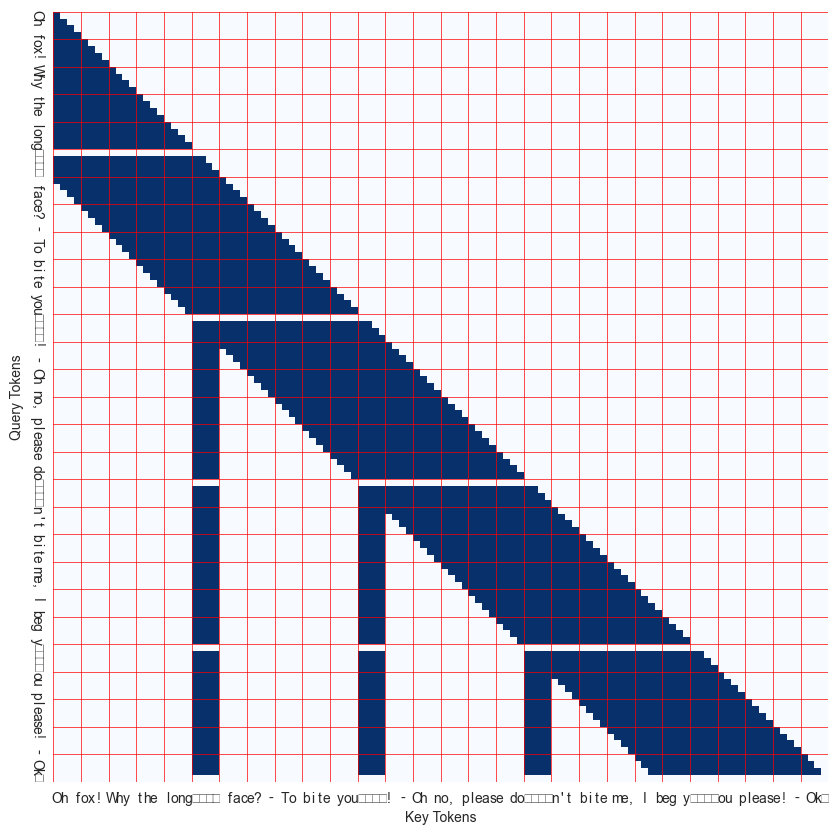

In [59]:
def visualize_mask(mask, tokens, title="", block_size=4):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(
        mask.numpy(), 
        cmap="Blues", 
        cbar=False, 
        annot=False, 
        xticklabels=[chr(c) for c in tokens[0]], 
        yticklabels=[chr(c) for c in tokens[0]],
    )
    
    # Add red grid lines for the block_size
    height, width = mask.shape
    for i in range(0, height, block_size):
        ax.axhline(i, color='red', linewidth=0.5)
    for j in range(0, width, block_size):
        ax.axvline(j, color='red', linewidth=0.5)
        
    plt.yticks(rotation=270)
    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()
    
    
text = "Oh fox! Why the long face? - To bite you! - Oh no, please don't bite me, I beg you please! - Ok"

tokenizer = Tokenizer()
compression_strength = 5
block_size = 4
window_size = (compression_strength + 1) * block_size

tokens = tokenizer.encode(text)
inputs = Collator(padding_token=127)([prepare_for_model(tokens, block_size=block_size)])

tokens, abs_pos = inputs['tokens'], inputs['absolute_pos']

seq_length = len(tokens[0])

# additive
causal_window_mask = get_causal_window_mask(cache_size=0, window_size=window_size)
anyone_attends_to_accum_or_sink_mask = get_anyone_attends_to_accum_or_sink_mask(tokens, accum_token=11, sink_token=12, cache_size=0)

# multiplicative
isolate_padding_mask = get_isolate_padding_mask(tokens, pad_token=127, cache_size=0)
sink_attends_to_nothing_mask = get_sink_attends_to_nothing_mask(tokens, sink_token=12, cache_size=0)


# 1) Only causal mask
block_mask_causal = torch.zeros((seq_length, seq_length), dtype=torch.bool)
for q in range(seq_length):
    for kv in range(seq_length):
        block_mask_causal[q, kv] = causal_window_mask(0, 0, q, kv)
        block_mask_causal[q, kv] |= anyone_attends_to_accum_or_sink_mask(0, 0, q, kv)
        
        block_mask_causal[q, kv] &= isolate_padding_mask(0, 0, q, kv)
        block_mask_causal[q, kv] &= sink_attends_to_nothing_mask(0, 0, q, kv)
visualize_mask(block_mask_causal, tokens, title="", block_size=block_size)

# Generation

In [10]:
@torch.no_grad()
def generate(
        seed: str,
        model: Generator,
        tokenizer: Tokenizer,
        *,
        device: str,
        max_length: int,
        block_size: int = 128,
        compression_strength: int = 5,
        amp_enabled: bool = True,
        progress_bar: bool = True,
        pa_weights: list[float] | None = None,
        predict_ahead: int = 16,
        stride: int = 1,
        compress_cache: bool = True,
) -> str:
    model.eval()
    
    if pa_weights is None:
        pa_weights = [1 / (idx + 1) for idx in range(predict_ahead)]
        
    assert len(pa_weights) == predict_ahead
    
    # normalize the weights
    pa_weights = torch.tensor(pa_weights, device=device).reshape(1, predict_ahead, 1)
    pa_weights /= pa_weights.sum()

    model = model.to(device)

    tokens = tokenizer.encode(seed)
    next_predictions = torch.zeros((1, predict_ahead, tokenizer.size), dtype=torch.float, device=device)

    past_keys = None
    past_values = None
    past_compression = None

    for _ in tqdm(
            range(len(tokens), max_length, stride),
            total=max_length - len(tokens),
            desc="Generating",
            disable=not progress_bar
    ):
        with torch.amp.autocast(enabled=amp_enabled, device_type=device):
            outputs = model(
                # batch_size = 1
                **Collator(padding_token=tokenizer.pad_token)([prepare_for_model(
                    tokens,
                    pad_token=tokenizer.pad_token,
                    block_size=block_size,
                    compression_strength=compression_strength,
                )]),
                past_keys=past_keys,
                past_values=past_values,
                past_compression=past_compression,
                output_past=True,
                compress_cache=compress_cache
            )
            outputs: ModelOutput
            
        past_compression = outputs.cache_compression_mask
        
        # update each predict-ahead token logits, respecting the weight of the prediction
        next_predictions += outputs.logits[:, 0, :] * pa_weights  # TODO: get last non-special
        
        # predict next stride tokens
        for _ in range(stride):
            # predicted token is at position 0
            predicted_token = torch.argmax(next_predictions[:, 0], dim=-1) 
            tokens = torch.concatenate([tokens, predicted_token.view(1)], dim=0)
            
            # prepare for next round of generation
            next_predictions = torch.roll(next_predictions, -1, dims=1)
            next_predictions[:, -1:, :] = 0
            past_compression = torch.concatenate([past_compression, past_compression.new_ones(size=(1,))], dim=0)

        past_keys = outputs.keys
        past_values = outputs.values

    return tokenizer.decode(tokens)

# Performance comparison depending on the sparsity level (H100 GPU, Shakespear texts)

By length

In [13]:
class DummyModel(Generator):
    def __init__(
            self, 
            vocab_size: int = 128,
            n_layers: int = 36,
            head_dim: int = 128,
            n_heads: int = 64, 
            pad_token: int = 127,
            accum_token: int = 11,
            sink_token: int = 12,
            predict_ahead: int = 16,
            block_size: int = 128,
            compression_strength: int = 5,
            device: str = 'cpu',
            attn_impl: str = 'flex',
            model_dtype: str | torch.dtype = torch.bfloat16
    ):
        nn.Module.__init__(self)

        self.n_layers = n_layers
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.hidden_dim = self.n_heads * self.head_dim
        
        self.block_size = block_size
        self.compression_strength = compression_strength
        self.window_size = self.block_size * (self.compression_strength + 1)
        
        self.vocab_size = vocab_size
        self.predict_ahead = predict_ahead
        
        self.pad_token = pad_token
        self.accum_token = accum_token
        self.sink_token = sink_token
        
        self.attn_impl = attn_impl
        
        self.lm_head = nn.Linear(self.hidden_dim, self.vocab_size, device=device, dtype=model_dtype)
        self.emb = nn.Embedding(self.vocab_size, self.hidden_dim, device=device, dtype=model_dtype)

    def forward(
            self,
            tokens: torch.Tensor,
            absolute_pos: torch.Tensor,
            is_special_mask: torch.Tensor,
            past_keys: list[torch.Tensor] | None = None,
            past_values: list[torch.Tensor] | None = None,
            past_compression_mask: torch.Tensor | None = None,
            output_past: bool = False,
            compress_cache: bool = True,
            **_,
    ):
        batch_size, seq_length = tokens.shape
        device = tokens.device
        assert device == self.emb.weight.device

        no_cache = (past_keys is None or not len(past_keys))
        
        if past_compression_mask is None:
            past_compression_mask = torch.ones_like(tokens, dtype=torch.bool)
        
        if compress_cache and not no_cache:                
            to_compress = torch.ones(seq_length, device=device, dtype=torch.bool)
            
            # all batches should have memory tokens in the same places
            mask = torch.eq(tokens, self.accum_token) | torch.eq(tokens, self.sink_token)
            etalon = mask[0]
            assert torch.eq(etalon.unsqueeze(0), mask).all()
            
            # do not compress accum tokens
            to_compress[mask] = False
            
            # keep the last few tokens for the window attention
            to_compress[-self.window_size:] = False
            
            uncompressed_mask = ~to_compress
            cache_mask = uncompressed_mask[past_compression_mask]
            past_compression_mask &= uncompressed_mask
            
            past_keys = [cache.transpose(0, 1)[cache_mask].transpose(0, 1) for cache in past_keys]
            past_values = [cache.transpose(0, 1)[cache_mask].transpose(0, 1) for cache in past_values]
        
        tokens = tokens.transpose(0, 1)[past_compression_mask].transpose(0, 1)
        absolute_pos = absolute_pos.transpose(0, 1)[past_compression_mask].transpose(0, 1)
        
        cache_size = past_keys[0].shape[1] if not no_cache else 0

        hidden = self.emb(tokens[:, cache_size:])

        if no_cache:
            past_keys = [hidden.new_empty((batch_size, 0, self.hidden_dim)) for _ in range(self.n_layers)]
            past_values = [hidden.new_empty((batch_size, 0, self.hidden_dim)) for _ in range(self.n_layers)]
            
        new_len = seq_length - cache_size

        if self.attn_impl == 'flex':
            mask = create_mask(
                tokens, 
                window_size=self.window_size,
                cache_size=cache_size,
                pad_token=self.pad_token,
                accum_token=self.accum_token,
                sink_token=self.sink_token,
            )
        else:
            mask = None  # TODO?

        for layer_idx in range(self.n_layers):
            hidden_k = torch.concatenate([hidden, past_keys[layer_idx]], dim=1)
            hidden_v = torch.concatenate([hidden, past_values[layer_idx]], dim=1)

            if output_past:
                # update cache
                past_keys[layer_idx] = hidden_k
                past_values[layer_idx] = hidden_v

            # calculate new hidden for next layer

            # (B, S, H) -> (B, kh, S, Hh)
            hidden = hidden.view(batch_size, new_len, self.n_heads, self.head_dim).transpose(1, 2)
            hidden_k = hidden_k.view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
            hidden_v = hidden_v.view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)

            if self.attn_impl == 'flex':
                hidden = flex_attention(hidden, hidden_k, hidden_v, block_mask=mask)
            elif self.attn_impl == 'sdpa':
                hidden = scaled_dot_product_attention(hidden, hidden_k, hidden_v, is_causal=True)
            hidden = hidden.transpose(1, 2).contiguous().view(batch_size, new_len, -1)

        return ModelOutput(
            # project from hidden space to logit space
            logits=self.lm_head(hidden).reshape(batch_size, new_len, self.predict_ahead, self.vocab_size),
            keys=past_keys if output_past else None,
            values=past_values if output_past else None,
            cache_compression_mask=past_compression_mask if output_past else None,
        )

tokenizer = Tokenizer()
test_str = 'O God, O God! ' * 100

In [66]:
test = torch.randn((16, 64, 128))
mask = torch.randint(0, 2, size=(64,), dtype=torch.bool)
test.transpose(0, 1)[mask].transpose(0, 1).shape

torch.Size([16, 34, 128])

In [16]:
model = torch.compile(DummyModel(device='cuda', attn_impl='flex'), dynamic=True)
generate(test_str, model, tokenizer, max_length=len(test_str) + 1000, device='cuda', amp_enabled=True);

Generating:   0%|          | 0/999 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7d5f0ac8c040>
Traceback (most recent call last):
  File "/mloscratch/homes/shcherba/conda/envs/char-llm/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/mloscratch/homes/shcherba/conda/envs/char-llm/lib/python3.11/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


In [17]:
generate(test_str, model, tokenizer, max_length=len(test_str) + 1000, device='cuda', amp_enabled=True);

Generating:   0%|          | 0/999 [00:00<?, ?it/s]

In [18]:
model = torch.compile(DummyModel(device='cuda', attn_impl='sdpa'), dynamic=True)
generate(test_str, model, tokenizer, max_length=len(test_str) + 1000, device='cuda', amp_enabled=True);

Generating:   0%|          | 0/999 [00:00<?, ?it/s]

In [19]:
generate(test_str, model, tokenizer, max_length=len(test_str) + 1000, device='cuda', amp_enabled=True);

Generating:   0%|          | 0/999 [00:00<?, ?it/s]

In [15]:
base = 128
mult_min = 2
mult_max = 100
n_trials = 10

data = []
for impl in ['flex', 'sdpa']:
    model = torch.compile(DummyModel(device='cuda', attn_impl=impl), dynamic=True)
    model.eval()
    
    print('Warmup')
    
    # warmup for compile
    for _ in range(100):
        with torch.no_grad():
            model(**Collator(padding_token=127, move_to='cuda')(
                [tokenizer.encode('Eat the rich, feed the poor!' * 10)] 
            ))
    
    print('Warmup done')
    
    for length_mult in tqdm(range(mult_min, mult_max), total=mult_max - mult_min):
        length = base * length_mult
        dataset = Dataset('data/tinyshakespeare/train', start_token=2, target_length=length)
        
        collator = Collator(padding_token=127, move_to='cpu')
        loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8, collate_fn=collator)
        
        # Record processing time and memory usage for each batch
        for batch, _ in zip(loader, range(n_trials)):
            # Measure time and memory
            start_time = time.time()
            torch.cuda.reset_peak_memory_stats(device=None)
            
            # Process the batch with the model
            with torch.no_grad():
                cuda_batch = {k: v.to('cuda') for k, v in batch.items()}
                model(**cuda_batch)
            
            # Calculate time taken and memory used
            time_taken = time.time() - start_time
            peak_mem = torch.cuda.max_memory_allocated(device=None)
            
            # Record results
            data.append({
                'impl': impl,
                'sequence_length': length,
                'time_taken': time_taken,
                'memory_used': peak_mem
            })

Warmup
Warmup done


  0%|          | 0/98 [00:00<?, ?it/s]

unknown:0: unknown: block: [11,0,0], thread: [96,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [97,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [98,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [99,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [100,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [101,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [102,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [103,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` failed.
unknown:0: unknown: block: [11,0,0], thread: [104,0,0] Assertion `index out of bounds: 0 <= tmp4 < 128` fail

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Model

Llama-like architecture without GQA.

In [10]:
class LLM(nn.Module):
    pass

# Training

In [ ]:
from torch.utils.data import Dataset

class CharDataset(Dataset):
    """
    Emits batches of characters.

    Adapted from "https://github.com/karpathy/minGPT".
    """

    def __init__(self, config, data):

        chars = ... # get characters from the input data
        self.stoi = { ch:i for i,ch in enumerate(chars) } # map characters to integer indices

        ...

    def get_vocab_size(self):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        # encode every character to an integer
        # return the chunk and the shifted version as tensors
        pass

In [ ]:
def train(model, dataset, **kwargs):
    pass